# 금공프3 Final

20249433 MFE 최재필

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import math
import random

## 1. Mean-Variance Optimization

In [2]:
asset = pd.read_csv('it.csv')
asset.set_index('Date', inplace=True)
asset.head() # 다행히 데이터에 nan이 없다.

,AAPL,GOOG,MSFT,IBM,T
Date,,,,,
2018-01-02,169.714086,1065.00,84.484767,147.537554,36.382354
2018-01-03,169.684530,1082.48,84.877948,151.593043,35.542180
2018-01-04,170.472706,1086.40,85.624992,154.663355,35.872586
2018-01-05,172.413591,1102.23,86.686581,155.418977,36.004748
2018-01-08,171.773197,1106.94,86.775047,156.356330,36.108590


In [3]:
asset.shape

(232, 5)

### (1) `MVportfolio` 

In [4]:
def MVportfolio(asset, mu_p):
    asset_2d = asset.to_numpy()

    X = np.log(asset_2d[1:]/asset_2d[:-1]) # 수익률 (수익률은 log 차분 수익률로 계산)
    Q = np.cov(X.T) # 공분산 행렬
    r = np.nanmean(X, axis=0).reshape(-1, 1) # 기대값 (수익률 평균)
    l = np.ones(r.shape) # 1 벡터
    zero = np.zeros(l.shape) # 0 벡터

    # 라그랑지안 편미분 방정식 행렬
    Q_l_r = np.hstack([Q, l, r]) # 목적함수 편미분 
    l_0_0 = np.hstack([l.T, [[0]], [[0]]]) # 제약조건 1: 가중치 합 = 1
    r_0_0 = np.hstack([r.T, [[0]], [[0]]]) # 제약조건 2: 수익률 = mu_p

    L = np.vstack([Q_l_r, l_0_0, r_0_0]) # 완성된 라그랑지안 

    zero_l_mu = np.vstack([zero, [[1]], [[mu_p]]]) # 우변
    L_inv = np.linalg.inv(L) # 역행렬 계산

    w_lmda1_lmda2 = L_inv @ zero_l_mu # 라그랑지안 해벡터

    w = w_lmda1_lmda2[:-2] # 최적 포트폴리오 가중치
    lmda1 = w_lmda1_lmda2[-2] # 라그랑지안 해벡터 람다1
    lmda2 = w_lmda1_lmda2[-1] # 라그랑지안 해벡터 람다2

    var = w.T @ Q @ w # 최적 포트폴리오 분산

    return w, var

### (2) Efficient Frontier

In [5]:
mu_p_min = -0.001
mu_p_max = 0.001

mu_p_range = np.linspace(mu_p_min, mu_p_max, 100)

In [6]:
asset_2d = asset.to_numpy()

X = np.log(asset_2d[1:]/asset_2d[:-1]) # 수익률 (수익률은 log 차분 수익률로 계산)
r = np.nanmean(X, axis=0).reshape(-1, 1) # 기대값 (수익률 평균)

In [7]:
w_var = [MVportfolio(asset, mu_p) for mu_p in mu_p_range]
var_ret = np.array([(var, w.T @ r) for w, var in w_var]).reshape(len(w_var), 2)

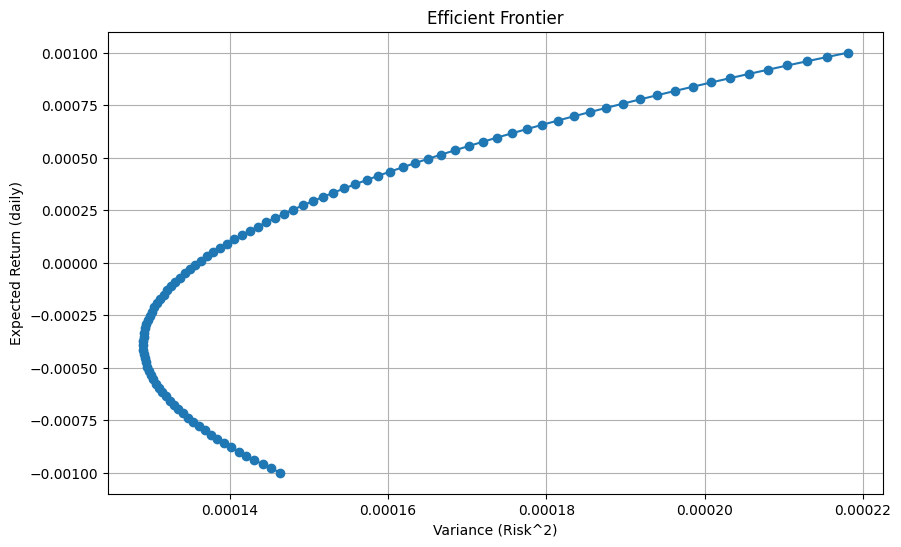

In [8]:
# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(var_ret[:, 0], var_ret[:, 1], marker='o', linestyle='-')

plt.title('Efficient Frontier')
plt.xlabel('Variance (Risk^2)')
plt.ylabel('Expected Return (daily)')
plt.grid(True)
plt.show()

## 2. Momentum

In [9]:
# (1) price 파일 불러온 뒤 date 열을 DatetimeIndex로 변경한 뒤 인덱스로 설정
price = pd.read_csv('price.csv')
price['date'] = pd.to_datetime(price['date'])
price.set_index('date', inplace=True)
price.head() 

# 참고: 데이터에 nan이 많음. 
# 대부분은 상장폐지 종목 또는 상장 이전 종목이라고 판단됨.
# 하지만 전 기간 nan인 종목도 있음. 

,X005930,X000660,X051910,X207940,X035420,X035720,X005380,X006400,X068270,X000270,...,X058220,X038160,X033600,X195440,X058420,X121890,X114570,X347140,X080440,X158310
date,,,,,,,,,,,,,,,,,,,,,
2018-05-23,51800,95300.0,343500.0,399500.0,136994,22580,144500.0,204500,237286,33650,...,2500.0,7790.0,7460.0,63720.0,13298.0,2905.0,26630.0,NaN,5079.0,10250.0
2018-05-24,51400,94600.0,345000.0,418000.0,136193,22681,140000.0,204500,243737,32700,...,2383.0,7880.0,7310.0,63536.0,13226.0,2890.0,25339.0,NaN,5005.0,9300.0
2018-05-25,52700,95200.0,352500.0,430500.0,137194,22480,139000.0,207000,253413,32250,...,2400.0,7770.0,7200.0,63997.0,13265.0,2830.0,25574.0,NaN,4870.0,8920.0
2018-05-28,52300,94500.0,352000.0,429000.0,136193,21677,138500.0,209000,249726,32300,...,2403.0,7980.0,7370.0,62800.0,13226.0,2790.0,25339.0,NaN,4980.0,8740.0
2018-05-29,51300,94800.0,343500.0,433000.0,133789,21677,140000.0,211500,249266,31650,...,2350.0,8930.0,7240.0,60866.0,13121.0,2740.0,26281.0,NaN,4631.0,8720.0


In [10]:
price.shape

(565, 2203)

In [11]:
# (2) 2019년도 자료만 선택
price_sub = price.loc['2019-01-01':'2019-12-31', :].copy() 

In [12]:
# (3) 누적곱으로 수익률 계산 (Series 객체로 저장)
cum_ret = price_sub.pct_change(fill_method=None).add(1).prod() - 1

In [13]:
# (4) 누적 수익률 상위 10개 종목 출력
top10_cumret = cum_ret.sort_values(ascending=False).head(10)
top10_cumret

X088290    13.576271
X101360     7.400000
X078130     4.155172
X139670     4.049401
X032500     3.443478
X009190     2.992042
X138080     2.719443
X336370     2.693285
X033250     2.536524
X214150     2.498146
dtype: float64

<Axes: title={'center': '2019 Top 1 Cumulative Return'}, xlabel='date'>

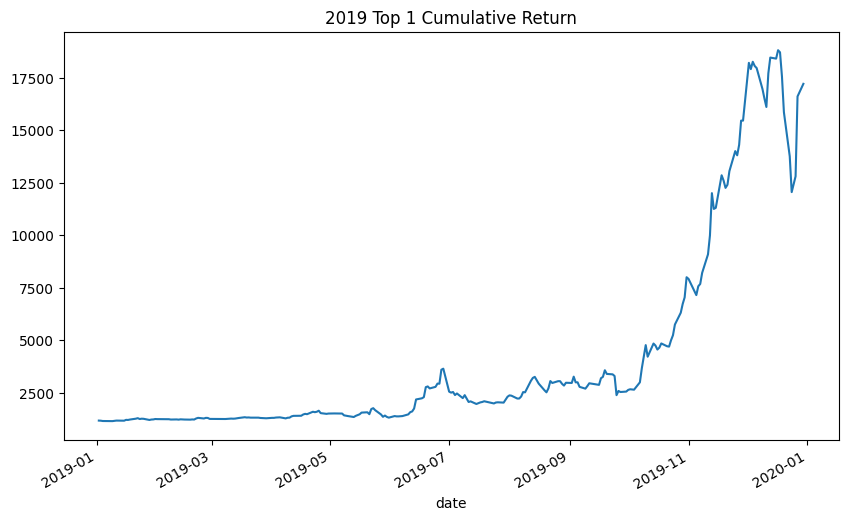

In [14]:
price_sub[top10_cumret.index[0]].plot(figsize=(10, 6), title='2019 Top 1 Cumulative Return')

In [15]:
# (5) 종목별 연율화 변동성 계산 (252일 기준, Series 객체로 저장)
std = price_sub.pct_change(fill_method=None).std() * np.sqrt(252)

In [16]:
# (6) std가 0인 경우와 nan인 경우를 제외
std = std[std != 0].dropna()

In [17]:
# (7) 샤프지수 계산
shrp = cum_ret / std

In [18]:
# (8) 샤프지수가 nan인 경우 shrp 최소값으로 대체
shrp = shrp.fillna(shrp.min())

In [19]:
# (9) 샤프지수 상위 10개 종목 출력
top10_shrp = shrp.sort_values(ascending=False).head(10)
top10_shrp

X088290    12.317314
X032500     5.582321
X101360     5.364799
X139670     4.570944
X138080     4.033614
X078130     3.760220
X214150     3.711147
X036540     3.707145
X097520     3.624222
X000990     3.552103
dtype: float64

In [20]:
# (10) Top 10 종목의 최종 결과 출력

top10_shrp_stocks = top10_shrp.index

final_result = pd.DataFrame(
    data=zip(
        cum_ret[top10_shrp_stocks],
        std[top10_shrp_stocks],
        shrp[top10_shrp_stocks]
        ),
    index=top10_shrp_stocks,
    columns=['cum_ret', 'std', 'shrp']
)

final_result

,cum_ret,std,shrp
X088290,13.576271,1.102210,12.317314
X032500,3.443478,0.616854,5.582321
X101360,7.400000,1.379362,5.364799
X139670,4.049401,0.885900,4.570944
X138080,2.719443,0.674195,4.033614
X078130,4.155172,1.105034,3.760220
X214150,2.498146,0.673147,3.711147
X036540,2.142336,0.577894,3.707145
X097520,1.903846,0.525312,3.624222
X000990,1.628571,0.458481,3.552103


## 3. Monte-Carlo Simulation

In [21]:
def ECallSimul_1(S0, K, T, r, sigma, M, l=250000):
    S = []
    dt = T/M
    for i in range(l):
        path = []
        
        for t in range(M+1):
            if t == 0:
                path.append(S0)
            else:
                z = random.gauss(0., 1.)
                St = path[t-1] * math.exp( (r - 0.5*sigma**2)*dt + sigma*math.sqrt(dt)*z )
                path.append(St)
            
        S.append(path)
        
    sum_val = 0.

    for path in S:
        sum_val += max(path[-1] - K, 0)
    
    C0 = math.exp(-r*T) * sum_val / l

    return round(C0, 3)

### (1) 가능한 모든 부분을 `numpy`를 활용하는 것으로 수정

In [22]:
def ECallSimul_2(S0, K, T, r, sigma, M, l=250000):
    dt = T/M

    Z = np.random.randn(l, M)
    S = np.zeros((l, M+1)) # 맨 앞에 S0를 넣기 위해 M+1
    S[:, 0] = S0

    drift = (r - 0.5*sigma**2)*dt
    diffusion = sigma * np.sqrt(dt) * Z

    S[:, 1:] = S0 * np.exp(np.cumsum(drift + diffusion, axis=1))

    payoffs = np.maximum(S[:, -1] - K, 0)
    C0 = np.exp(-r*T) * np.mean(payoffs)

    return round(C0, 3)

### (2) 연산시간 비교

In [23]:
S0 = 100.
K = 105.
T = 1.
r = 0.05
sigma = 0.2
M = 50
l = 250000

In [24]:
%time C0_1 = ECallSimul_1(S0, K, T, r, sigma, M, l)

CPU times: total: 7.81 s
Wall time: 11.7 s


In [25]:
%time C0_2 = ECallSimul_2(S0, K, T, r, sigma, M, l)

CPU times: total: 359 ms
Wall time: 613 ms
